# Дальность - Доплер
---

__Предыдущие разделы__
- Радиолокационные данные
- Дальность

Для упрощения работы и анализа радиолокационных данных существует множество открытых библиотек на github. Однако есть наиболее оконченная такая как ```openradar```. Вся дальнейшая работа основана на наработках данного репозитория.
```python 
!pip install openradar # Библиотека для работы с радаром
import mmwave as mm    # импорт библиотеки для работы с радаром
```
Ссылка на github репозиторий: [OpenRadar on github](https://github.com/PreSenseRadar/OpenRadar)  
Ссылка на документацию модуля: [Welcome to the mmwave docs!](https://openradar.readthedocs.io/en/latest/)

## Введение - Вернемся к Нашему Предыдущему примеру

<img src = "https://github.com/PreSenseRadar/OpenRadar/blob/master/Presense%20Applied%20Radar/assets/speedometer.png?raw=true" alt = "drawing" width = "150" align = 'right'>

Вспомните наш пример с фильмом: мы выполнили несколько шагов по извлечению информации о дальности из данных нашего радара. Это хорошо для реконструкции драматической сцены фильма, но все еще многого не хватает. Одна часть ключевой информации, которая не обязательно отображается на экране, все еще остается открытой. Это, конечно, скорость. Используя радар, мы должны быть в состоянии определить, насколько быстро объект приближается или мимолетен.

## Что видит Радар

В прошлый раз мы использовали способ захвата выборок АЦП для определения диапазона. Мы сказали, что, поскольку они были захвачены на равном расстоянии друг от друга во времени, они сформировали своего рода журнал времени, к которому мы могли получить доступ. Концептуально, давайте подумаем о том, что произошло бы, если бы мы использовали ту же технику для захвата ЛЧМ, а также образцов. 

Какой-нибудь объект перед радаром отразит части первого звукового сигнала. Теперь второй, третий и так далее ЛЧМ попадают в этот объект и отражаются. Для простоты давайте предположим, что объект остается в пределах одного диапазона в течение всего кадра и движется с постоянной скоростью. Должен быть какой-то набор выборок по отдельным ЛЧМ, которые содержат эту ценную информацию. Подумайте о том, как каждый из них выглядит относительно предыдущего и следующего.

## Эффект Доплера

Эффект Доплера - это то, что происходит, когда волна попадает на движущийся объект. Логика, стоящая за этим, проста: если вы бросите прыгающий мяч во что-то движущееся, он либо вернется быстрее, либо медленнее, чем обычно. Что касается волн, то это влияет на частоту волны после того, как она отражается от объекта, поскольку пики в волне либо отдаляются, либо сближаются. Это означает, что существует некоторая связь между частотой волны и скоростью объекта, в который она попадает (дополнительно источник волны, если он еще не неподвижен). Элементарное уравнение для этого следующее:

$$f' = \frac{v+v_0}{v-v_s}f$$

Однако это уравнение работает со звуковыми волнами (которые не подчиняются уравнению $c=\lambda f$, которое генерирует радар электромагнитных волн). Нам нужен новый метод для определения этого изменения скорости с помощью волн, которые движутся со скоростью света.

## Открывая смысл в ЛЧМ

В дополнение к нескольким выборкам АЦП у нас есть несколько сигналов ЛЧМ. Для объекта на расстоянии $x$ от радара, когда мы получим соответствующую выборку АЦП, произведение будет комплексным числом с некоторой фазой. Если объект удаляется от радара, соответствующая выборка АЦП второго сигнала поступит с очень небольшой задержкой. Это происходит потому, что объект также немного отодвинулся за этот ничтожный промежуток времени. Хотя это движение незначительно, изменение фазы волны можно четко увидеть.

# Обработка Доплеровской Информации
***

## Шаг 1 - Дальностный БПФ

Давайте начнем с того, что мы уже сделали, но немного расширим его. Из предыдущей работы мы знаем, что мы можем выполнить БПФ по выборкам данных, которые мы получаем, чтобы получить информацию о дальности. Однако данные, которые я предоставляю на этот раз, взяты из целого **кадра** вместо одного **ЛЧМ**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path2file = 'data/simple_frame.npy';

frame = np.load(path2file);
print(f'Форма кадра: {frame.shape}');

Форма кадра: (128, 256)


In [4]:
range_plot = np.fft.fft(frame, axis = 1);

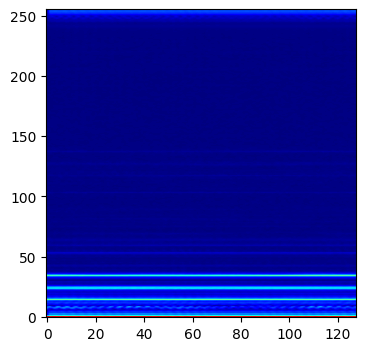

In [5]:
fig1 = plt.figure(figsize = (4, 4));
plt.imshow(np.abs(range_plot).T, cmap = 'jet', origin = 'lower', aspect = 'auto', interpolation = 'gaussian');

## Шаг 2 - Доплеровский БПФ

Глядя на созданный график, начинает казаться, что радар определенно видит что-то на разных расстояниях. Примечательно, что мы можем видеть пиковые линии в ячейках диапазона **~40 и ~115**. Тем не менее, трудно сказать точно, что именно. Теперь мы должны попытаться также получить информацию о скорости.

```python
Задание: Необходимо выполнить БПФ по строкам (медленной шкале) - для получения скоростей
Выходные данные: range_doppler [doppler_bins, range_bins]
Детали:  
```

In [6]:
# Проведите последовательный БПФ по ЛЧМ
range_doppler = np.fft.fft(range_plot, axis = 0);

# Центрирование БПФ элементов
range_doppler = np.fft.fftshift(range_doppler, axes = 0); 

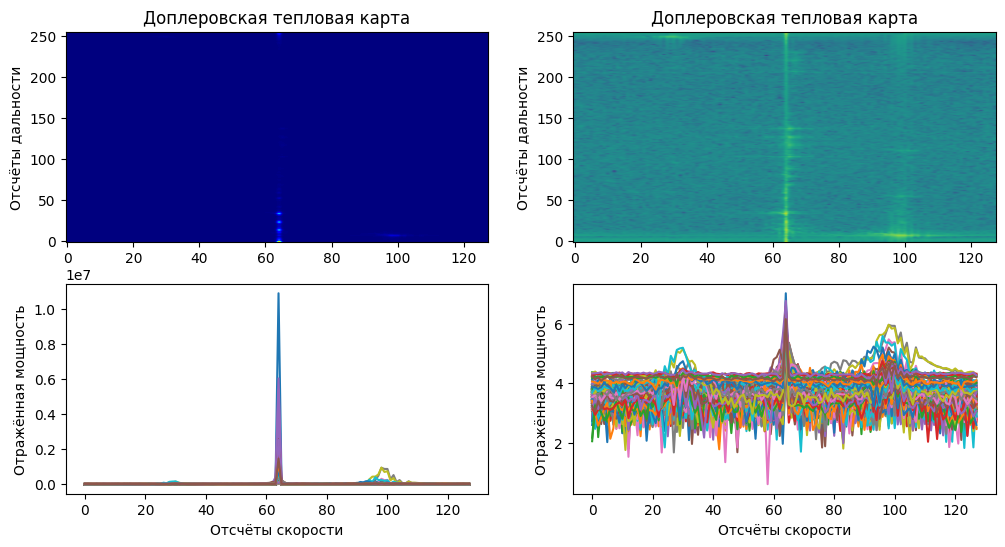

In [7]:
# Визуализация графика дальность-Допплер
fig2 = plt.figure(figsize = (12, 6));
axes = fig2.subplots(nrows = 2, ncols = 2);

axes[0, 0].imshow(np.abs(range_doppler).T, cmap = 'jet', origin = 'lower', aspect = 'auto', interpolation = 'gaussian');
axes[0, 1].imshow(np.log10(np.abs(range_doppler).T), cmap = 'viridis', origin = 'lower', aspect = 'auto', interpolation = 'gaussian');

axes[1, 0].plot(np.abs(range_doppler));
axes[1, 1].plot(np.log10(np.abs(range_doppler)));

axes[1, 0].set_xlabel('Отсчёты скорости');
axes[1, 1].set_xlabel('Отсчёты скорости');

axes[0, 0].set_title('Доплеровская тепловая карта');
axes[0, 1].set_title('Доплеровская тепловая карта');

axes[0, 0].set_ylabel('Отсчёты дальности');
axes[0, 1].set_ylabel('Отсчёты дальности');

axes[1, 0].set_ylabel('Отражённая мощность');
axes[1, 1].set_ylabel('Отражённая мощность');

Интересно, что определенно есть больше вещей, которые мы можем определить по этим графикам, просто расшифровав скорость, но сначала нам нужно знать, как их расшифровать. Это просто и очень похоже на расшифровку диапазона из ячеек диапазона. Кроме того, мы изменили БПФ по ЛЧМ, чтобы сделать его более интуитивным для понимания. Эта линия посередине в доплеровском отсеке 64 называется нулевым доплеровским, что означает, что все вдоль этой линии статично / не движется относительно радара. Это означает, что все, что находится слева (ячейки < 64), является отрицательным доплеровским, или движется к радару и наоборот для другой половины ячеек доплера.

Некоторые вещи, которые вы, возможно, наблюдали:
1. Большая часть принятого сигнала переводится в нулевой доплер, что имеет смысл, если вы подумаете об этом, потому что большинство объектов вокруг нас (и радар) не движутся и, следовательно, нулевой доплер относительно нас.
2. Графики показывают, что в диапазоне bin ~ 40 слева есть группа пиков интенсивности, что означает, что объект, скорее всего, движется в направлении радара.
3. Кроме того, в диапазоне bin ~ 115 мы видим пик в середине доплеровских ячеек, что означает, что перед радаром, вероятно, находится статический объект с высокой отражающей способностью. Эти описанные пики более четко показаны на втором графике.

### Примечание

Возможно, вы заметили некоторые вещи после завершения этих двух шагов. 
1. Почему мы выбрали диапазон FFT / что, если нам не нужен диапазон?
    - На самом деле вам это не нужно, но для многих задач требуется информация о дальности, которая поступает с радара. Если вам не нужна эта информация, то вам, вероятно, сойдет с рук, что вы ее не принимаете.
2. Почему нам пришлось использовать БПФ диапазона до того, как мы выполнили доплеровское БПФ?
    - Опять же, без причины. Кроме того, в этом случае сохраняются свойства 2D-БПФ, и мы фактически можем работать в любом направлении. Я могу доказать это прямо здесь...

In [8]:
# Range FFT -> Doppler FFT
range_bins = np.fft.fft(frame, axis = 1);
fft_2d = np.fft.fft(range_bins, axis = 0);

# Doppler FFT -> Range FFT
doppler_bins = np.fft.fft(frame, axis = 0);
rfft_2d = np.fft.fft(doppler_bins, axis = 1);

print('Максимальная разница в мощности: ', np.abs(fft_2d - rfft_2d).max());

Максимальная разница в мощности:  9.599853366654507e-10


Который довольно близок к нулю (не обязательно равен нулю из-за ошибок округления на уровне битов)

## Шаг 3 - Преобразование единиц измерения

Все единицы данных, которые мы произвели, относятся к некоторому типу "bin". Аналогично разрешению по дальности, у нас есть доплеровское разрешение, известное как разрешение по скорости. Это можно применить аналогичным образом, но сначала давайте выведем уравнение. Снова мы начнем с некоторых заданных уравнений...

- $\omega = \frac{4\pi vT_c}{\lambda}$ - Частота вращения фазы из-за объекта, движущегося со скоростью $v$
    - $v$ - скорость
    - $T_c$ - период дискретизации
    - $\lambda$ - длина волны
- $\Delta\omega \gt \frac{2\pi}{N}$ - минимальное изменение поворота фазы, определяемое радаром
    - $N$ - число отсчетов

Теперь ваша очередь попытаться вывести наше уравнение разрешения скорости.

Для описанной системы разрешение дискретов результата БПФ может быть определено как:

$\Delta r = \frac{c}{2B} - $ разрешение дискрета по дальности. 

$\Delta v = \frac{c}{2f_{0}MT_{m}} - $ разрешение дискрета по скорости.

In [9]:
# Конфигурация выборки данных
c = 3e8;              # Скорость света (м/с)
sample_rate = 10000;   # Скорость, с которой радиолокационные выборки из АЦП (ksps - тысяч выборок (отсчетов) в секунду)
freq_slope = 9.994;      # Крутизна частоты ЛЧМ (МГц/мкс)
adc_samples = 256;    # Количество выборок (отсчетов) из одного ЛЧМ

start_freq = 60.00;      # Начальная частота ЛЧМ (ГГц)
idle_time = 100;       # Время до начала следующего ЛЧМ (мкс)
ramp_end_time = 60;   # Время после отправки каждого ЛЧМ (мкс)
num_chirps = 128;     # Число ЛЧМ на один кадр
num_tx = 1;           # Число передатчиков

In [10]:
# Разрешение по дальности
range_res = (c * sample_rate * 1e3) / (2 * freq_slope * 1e12 * adc_samples);
print(f'Разрешение по дальности: {range_res:.3f} [м]');

Разрешение по дальности: 0.586 [м]


In [11]:
# Разрешение по скорости
velocity_res = c / (2 * start_freq * 1e9 * (idle_time + ramp_end_time) * 1e-6 * num_chirps * num_tx);
print(f'Разрешение по скорости: {velocity_res:.3f} [м/с]');

Разрешение по скорости: 0.122 [м/с]


In [12]:
# Применение коэффициента разрешения диапазона к индексам дальности
ranges = np.arange(adc_samples) * range_res;
# Применение коэффициента разрешения по скорости к доплеровским индексам
velocities = np.arange(num_chirps) - (num_chirps // 2);
velocities = velocities * velocity_res;

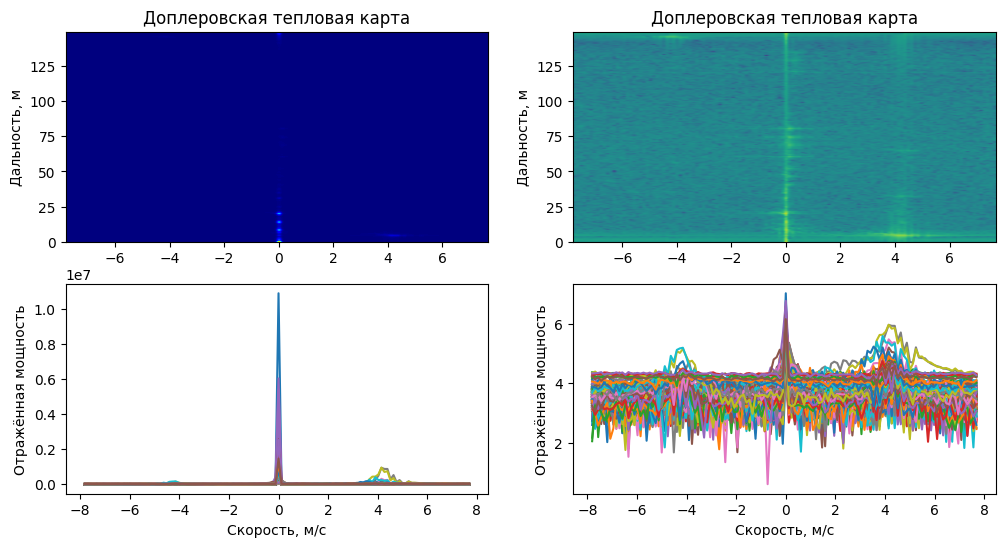

In [13]:
# Построение графика с учетом единиц
fig3 = plt.figure(figsize = (12, 6));
axes = fig3.subplots(nrows = 2, ncols = 2);

axes[0, 0].imshow(np.abs(range_doppler.T), extent = [velocities.min(), velocities.max(), ranges.min(), ranges.max()], origin = 'lower', cmap = 'jet', aspect = 'auto', interpolation = 'gaussian');
axes[0, 1].imshow(np.log10(np.abs(range_doppler.T)), extent = [velocities.min(), velocities.max(), ranges.min(), ranges.max()], origin = 'lower', cmap = 'viridis', aspect = 'auto', interpolation = 'gaussian');

axes[1, 0].plot(velocities, np.abs(range_doppler));
axes[1, 1].plot(velocities, np.log10(np.abs(range_doppler)));

axes[1, 0].set_xlabel('Скорость, м/с');
axes[1, 1].set_xlabel('Скорость, м/с');

axes[0, 0].set_title('Доплеровская тепловая карта');
axes[0, 1].set_title('Доплеровская тепловая карта');

axes[0, 0].set_ylabel('Дальность, м');
axes[0, 1].set_ylabel('Дальность, м');

axes[1, 0].set_ylabel('Отражённая мощность');
axes[1, 1].set_ylabel('Отражённая мощность');

In [14]:
range_min, range_max = 0, 15;

range_min = int(np.ceil(range_min / range_res));
range_max = int(np.ceil(range_max / range_res));

range_doppler_zoom = range_doppler[:, range_min:range_max];
range_doppler_zoom = range_doppler_zoom / np.max(range_doppler_zoom);

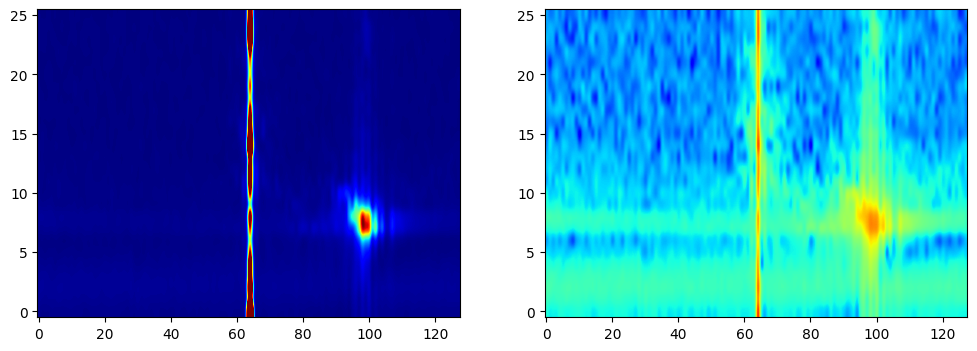

In [15]:
fig4 = plt.figure(figsize = (12, 4));
axes = fig4.subplots(nrows = 1, ncols = 2);

axes[0].imshow(np.abs(range_doppler_zoom.T), aspect = 'auto', origin = 'lower', cmap = 'jet', vmin = 0, vmax = 0.08, interpolation = 'gaussian');
axes[1].imshow(np.log10(np.abs(range_doppler_zoom.T)), aspect = 'auto', origin = 'lower', cmap = 'jet', interpolation = 'gaussian');

# Дополнительно

***

## Подведение итогов

В этом модуле рассмотрено, как радар использует преимущества **эффекта Доплера** для кодирования **скорости**. Небольшие изменения фазы отсчетов АЦП при многократном ЛЧМ могут использоваться для отслеживания микродвижений и затем могут быть преобразованы в скорость. Применяя эти знания, мы можем выполнить **доплеровское БПФ** точно так же, как БПФ диапазона, чтобы получить **доплеровскую тепловую карту диапазона**. Эта тепловая карта проста, но может быть очень эффективной при определении ряда параметров. Мы показали одно из применений этого, посмотрев на график доплеровского диапазона с двумя объектами на одном и том же расстоянии, но с противоположными скоростями. Диапазон сам по себе не смог бы помочь, так как **два объекта оказали бы аддитивное влияние на график диапазона**, но доплеровский БПФ дает нам **совершенно новое измерение** для работы.

## Комментарии

До сих пор мы делали упрощающее предположение о радаре, который мы используем. Это потому, что мы предположили, что радар, который мы используем, представляет собой простой одиночный приемник (RX) и одиночный передатчик (TX). Мы можем сделать намного лучше. Теперь у нас есть доступ к радарам, использующим настройки **MIMO TX/RX**. Точно так же, как мы узнали, что выборки АЦП и ЛЧМ дают нам ценные измерения, MIMO предоставляет нам новую информацию, **угол прихода**.